# 6.4 The Camera model

Until now we have first focused in stating the mathematical tools required to understand general vector/coordinates transformations and then to apply them to perform different image transformations. In fact, remember that in the previous notebook, we have transformed `WORLD` coordinates to `CAMERA` coordinates and the other way around, but that is just a **3D to 3D** transformation. But we have not properly addressed yet the process of transforming **`WORLD` coordinates (3D)** to **`IMAGE` coordinates (2D)** (and vice versa when possible), that is, how images are formed from real 3D objects. Well, this is the time, let's go for it!

In this notebook we will learn:

- the **Pinhole model**
- the **Camera model**

## Problem context - RGB-D images

RGB-depth (RGB-D) images are just like standard RGB images (where each pixel has information about each basic color: red, green and blue) but adding another information to each pixel: **its distance from the camera to the 3D point that is projected on it**. That is, this images contain not only photometric information but also geometric information.$\\[10pt]$

<img src="./images/kinect.png" width="600">$\\[5pt]$

In this figure, the left image is the standard RGB image while the right one is the *depth* band shown as a greyscale image (darker as the object is closer).

Although, this kind of images have been used for some decades now, in recent years they have become popular due to the development of inexpensive sensors, such as the [Microsoft's Kinect](https://en.wikipedia.org/wiki/Kinect) camera, that is able to directly provide this kind of images. In the entertainment bussiness, these images have been used for segmentating people using the system from the background of the image and inspecting their movements.

Roughly speaking, the working principle (called structured light) of these devices involves projecting an infrared pattern on the scene (see image below) and inspecting the deformations that such pattern undergoes due to the irregular surfaces where the light bounces. These deformations are directly related to the distance and position of the object.

<img src="./images/kinect_pattern.png" width="400">$\\[5pt]$

As RGB-D images actually provide provide depth information, they are a **good example for learning how image formation models work**, because we can turn images to 3D maps (using the depth) and the other way around (3D scene to 2D image plane).

## 6.4.1 The big picture
The process of converting world coordinates to image coordinates involves several steps that are applied by means of the concatenation of transformation expressed with homogeneous matrices/vectors. We address all this transformations in this notebook but first, we present the whole process in a single image, just to keep an eye on the big picture and then we will unravel its mysteries.

<img src="images/cameramodel.png" width="600">$\\[5pt]$

Let's do this step by step.

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from ipywidgets import interact, fixed, widgets
from mpl_toolkits.mplot3d import Axes3D
from math import sin, cos, radians, floor
images_path = './images/'
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
# %matplotlib notebook

import sys
sys.path.append("..")
from utils.plot3DScene import plot3DScene

### Homogeneous coordinates (again)

Apart from what we already know about homogeneous coordinates, an interesting property of them is that the **homogeneous coordinates of a point in the plane ($\mathbb{R}^2$) also represents a line passing through the origin in a reference frame parallel to the image plane**:$\\[10pt]$

<img src="./images/homogenous.png" width="600">$\\[5pt]$

That is, for a certain Cartesian point $p=(x,y)$, its homogeneous version $\tilde{p}=(kx,ky,k),\forall k$ represents a line in 3D from the start at the origin of coordinates. This is called a *projection line*. 
 
The projective plane, called $\mathbb{P}^2$, is the set of 3-tuples of real numbers such that $\begin{bmatrix}x_1 \\ x_2 \\ 1\end{bmatrix} \equiv k \begin{bmatrix}x_1 \\ x_2 \\ 1\end{bmatrix}, \ k \ne 0$, that is the set of all projective lines at a certain distance $1$ from the origin of coordinates.

So, in summary:
- A point in $\mathbb{P}^2$ (3-tuple) is represented in ($\mathbb{R}^3$) as a line passing through the origin.
- The component $k$ can be understood as the *depth*, as it indicates a specific point along the line.
 

## 6.4.2 The Pinhole model

The Pinhole camera model is the simplest model we can think to understand how image formation works. [[1]](https://web.stanford.edu/class/cs231a/course_notes/01-camera-models.pdf) Let’s image that we want to design a simple camera system that can record an image of an object in the 3D world. This camera system can be designed by placing a solid barrier with a small  (pin-size) aperture between the 3D object and a photographic film or sensor. 

<img src="./images/pinhole_intro.png" width="500">$\\[5pt]$

As this figure shows, each point on the 3D object bounces the light from the source and emits multiple rays of such light outwards. Without a barrier in place, every point on the film will be influenced by light rays emitted from every point on the 3D object. However, due to the barrier, only one (or a few) of these rays of light passes through the aperture and hits the film. Therefore, we can establish a one-to-one mapping between points on the 3D object and the film. The result is that the film gets exposed by an *image* of the 3D object by means of this mapping. This simple model is known as **the pinhole camera model**.

In the Pinhole model we want to project the 3D world (set of $\mathbf{p}_i=[X_i,Y_i,Z_i]^T$ points) in a plane called **image plane**. For that, we have a camera placed at $\mathbf{C} = [0,0,0]^T$ in the `WORLD` reference system (i.e. both the `WORLD` and the `CAMERA` systems are coincident). This camera have a fixed property $f$ called focal length, which indicates the distance between the **camera sensor** (placed in the interior of the camera and the origin of the `CAMERA` reference system). The camera sensor is the plane **where the scence of the real world is projected**:

<img src="./images/pinhole.png" width="400">$\\[5pt]$

To operate with this image formation model, we need to know how two processes: 
- to project a 3D world point to the image plane 
- to back-project a 2D point on the image plane to the 3D world.

For this, we are going to use the property of homogenous coordinates mentioned above.

### From 2D to 3D

Given a point $\mathbf{p} = [x,y]^T \in \mathbb{R}^2$ in the image, its **projection line** (in red in the figure above) in the camera system is very simple to compute by means of the line passing through the point $[x,y,f]^T \in \mathbb{R}^3$ (we have added the third component $f$ because the image plane is placed at a distance $f$ in the $Z$-axis of the camera reference system). In homogeneous coordinates, this line follows the expression:$\\[5pt]$

$$k \begin{bmatrix}x \\ y \\ f \end{bmatrix} \in \mathbb{P}^2$$

where $k$ indicates a specific 3D point along the projection line.

For instance, if we set $k=2$ we have the point:$\\[5pt]$

$$ \begin{bmatrix}2x \\ 2y \\ 2f \end{bmatrix} \in \mathbb{R}^3 \\[5pt]$$

Note that, in this expression, $k$ does not correspond directly to the depth of the 3D point, but we can fix this dividing by the focal length:$\\[5pt]$

$$k' \begin{bmatrix} x \ / \ f  \\ y \ / \ f \\ 1 \end{bmatrix} \in \mathbb{P}^2 \\[5pt]$$ 

Now that the third coordinate is 1, $k'$ indicates the depth of the 3D point, so that if we know that the depth of a pixel is 5, we only have to set $k'=5$ and we will have the 3D coordinates of the point.$\\[10pt]$

### From 3D to 2D
Let's have a look now to the process of projecting 3D points to 2D. Given any 3D point $\mathbf{M} = [X,Y,Z]^T \in \mathbb{R}^3$, we know that it have a projection point in the image plane $\mathbf{m} = [x,y]^T \in \mathbb{R}^2$.  

As seen before, the 3D point in the projection line of $m$ with depth $Z$ is:$\\[5pt]$

$$Z \begin{bmatrix} x \ / \ f  \\ y \ / \ f \\ 1 \end{bmatrix} = \begin{bmatrix} Zx \ / \ f  \\ Zy \ / \ f \\ Z \end{bmatrix} \in \mathbb{R}^3 \\[5pt]$$ 

So that we can find the 2D image coordinates of the projected point through:$\\[5pt]$

$$M = \begin{bmatrix}X \\ Y \\ Z \end{bmatrix} =  \begin{bmatrix} Zx \ / \ f  \\ Zy \ / \ f \\ Z \end{bmatrix} \longrightarrow \begin{eqnarray} X = \frac{Zx}{f}\ \rightarrow \ x = \frac{fX}{Z} \\[3pt] Y = \frac{Zy}{f} \ \rightarrow \ y = \frac{fY}{Z} \end{eqnarray} \\[5pt]$$ 

This way, the relationship between the 3D point and its projected 2D point is like this:$\\[10pt]$
<img src="./images/3dto2d.png" width="500">$\\[5pt]$

Note that this transformation is not linear, but **it becomes linear if we use homogenous coordinates!**:$\\[5pt]$

$$\begin{bmatrix} f &amp; 0 &amp; 0 &amp; 0 \\ 0 &amp; f &amp; 0 &amp; 0 \\ 0 &amp; 0 &amp; 1 &amp; 0 \end{bmatrix}\begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} = \begin{bmatrix} fX \\ fY \\ Z\end{bmatrix} \xrightarrow{\text{homogenous to cartesian}} \begin{bmatrix} fX \ / \ Z \\ fY \ / \ Z \end{bmatrix} \\[5pt]$$

### Summary
So, these equations relates 3D and 2D coordinates of a certain point in the real world and its projection in the image:

<img src="./images/pinhole_summary.png" width="600">$\\[5pt]$

Note that it is impossible to get the complete 3D position of a certain point from its coordinates in a single image because we need to know the $Z$ coordinate beforehand. That is because the set of 3D points that falls in the line from the optical center to the image point **all of them project at the exact same point in the image**! This also the reason why **we cannot determine the scale of the objects from a single image**, which is called the **scale indetermination** in monocular vision.

Usually, this transformation is made more general by decomposing it as $Z \tilde{\mathbf{m}} = \mathbf{K}_f\underbrace{\mathbf{P}_0\tilde{\mathbf{M}}_C}_{Z\tilde{\mathbf{m}}_1}\\[5pt]$, that is:

$$Z \underbrace{\begin{bmatrix} x  \\ y \\ 1 \end{bmatrix}}_{\tilde{\mathbf{m}}} = \underbrace{\begin{bmatrix} f &amp; 0 &amp; 0\\ 0 &amp; f &amp; 0  \\ 0 &amp; 0 &amp; 1\end{bmatrix}}_{\mathbf{K}_f}\underbrace{\begin{bmatrix} 1 &amp; 0 &amp; 0 &amp; 0\\ 0 &amp; 1 &amp; 0 &amp; 0  \\ 0 &amp; 0 &amp; 1 &amp; 0\end{bmatrix}}_{\mathbf{P}_0 = [\mathbf{I}|\mathbf{0}]}\begin{bmatrix} X  \\ Y \\ Z \\ 1 \end{bmatrix}$$

In this expression, called **perspective projection equation**, $\tilde{\mathbf{m}}$ is the homogeneous 2D point, $\mathbf{K}_f$ is called the **calibration matrix** and $\mathbf{P_0}$ represents a certain transformation between the `CAMERA` and the `WORLD` reference system, as we will see later.

<img src="./images/3dto2d-2.png" width="700">$\\[5pt]$

**<span style="color: red;">ASSIGNMENT 1 -- </span>**

Your first task is to transform the ten world points given in matrix `world` to coordinates in the image plane using a focal length of $f = 2.5$. You should use **only** linear transformations and express the result in **Cartesian coordinates**.

In [11]:
# %matplotlib notebook

# ASSIGNMENT 1 --
# World coordinates
world = np.array([[12,21,30,41,67,54,33,24,46,58],[21,26,34,23,42,67,76,54,42,37],[10,7,2,13,4,7,5,15,8,7]])

# Focal length
f = 2.5
world_homo=np.array([[12,21,30,41,67,54,33,24,46,58],[21,26,34,23,42,67,76,54,42,37],[10,7,2,13,4,7,5,15,8,7],[1,1,1,1,1,1,1,1,1,1]])
Kf = np.array([[f, 0, 0],[0, f, 0],[0, 0, 1]])
P0 = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0]])
Cartesian = Kf@P0@world_homo

Cartesian_hom = Cartesian / Cartesian[2,:]

Cartesian = Cartesian_hom[:2,:]

print(Cartesian)

[[ 3.          7.5        37.5         7.88461538 41.875      19.28571429
  16.5         4.         14.375      20.71428571]
 [ 5.25        9.28571429 42.5         4.42307692 26.25       23.92857143
  38.          9.         13.125      13.21428571]]


**Check if your results are correct**:

<font>**Expected output:**  </font>

    [[ 3.     7.5    37.5  7.885  41.875  19.286  16.5  4.  14.375   20.714]
     [ 5.25   9.286  42.   4.423  26.25   23.929  38.   9.  13.125   13.214]]


## 6.4.3 The camera model

The Pinhole model is a useful starting point for understanding the processes of image formation, but it still has several limitations because:

- the camera frame point $m$ has its coordinates expressed **in meters** within the camera sensor, but we want to know them in **pixels**.
- it assumes that the `CAMERA` and the `WORLD` reference systems **are coincident**, which, of course, is not generally the case.

This is where we define the **camera model**, which include some linear transformations for solving these limitations and allow us to address the complete problem of image formation as depicted in the big picture.$\\[10pt]$

<img src="images/cameramodel.png" width="600">$\\[5pt]$

Let's go step by step.

### Step 1: From the `WORLD` frame to the `CAMERA` frame

This transformation implies finding a rotation matrix $\mathbf{R}$ and a translation vector $\mathbf{t}$ that **relates the position and orientation of the camera w.r.t. the world**. This is a 3D to 3D transformation and we have used it in the previous notebooks.

As said before, the camera should not be at the world center, mainly because the camera will move within the world, or even because will be more than one camera in our perception system.$\\[10pt]$

<img src="images/world_camera.png" width="500">$\\[5pt]$

Remember that in notebook 6.1, we learned how to apply a rotation and a translation to a set of 3D points using homogeneous transformations:$\\[5pt]$

$$\mathbf{M}_C = \mathbf{R}\mathbf{M}_W + \mathbf{t} \ \xrightarrow{\text{In homogenous}} \ \tilde{\mathbf{M}}_C = \mathbf{D} \tilde{\mathbf{M}}_W$$

If we add this transformation to the Pinhole model, the new **perspective projection equation** takes the expression:

$$\lambda \tilde{\mathbf{m}} = \mathbf{K}_f \mathbf{P}_0 \tilde{\mathbf{M}}_C = \mathbf{K}_f \mathbf{P}_0 \mathbf{D} \tilde{\mathbf{M}}_W$$

which allow us to transform points in 3D within the `WORLD` reference system (in meters) to points in 2D in the image sensor (**also in meters!**).

### Step 2: From the sensor image to a computer image

Once we have obtained sensor image points, what we need to operate with images is the **image matrix coordinates** (in pixels! that is, *row and column* within the image matrix) of such points, which are the units we use in the computer in all the computer vision processes we have studied in this course.$\\[10pt]$

<img src="images/sensor_matrix.png" width="600">$\\[5pt]$

As you can see in the figure, both images are related by an **affine** transformation (i.e. a 2D homography as seen in *notebook 8.2*). As we know, affine transformations allow **rotation + translation + scale** (different for each axis). In this case we don't need any rotation, but axes **do scale**, and such scale represents the size in meters in the sensor of each pixel in the image:

$$\mathbf{m}' = \mathbf{A}\mathbf{m} + \mathbf{b} = \begin{bmatrix}k_x &amp; 0 \\ 0 &amp; k_y\end{bmatrix}\underbrace{\begin{bmatrix} x \\ y \end{bmatrix}}_{\text{meters}} + \underbrace{\begin{bmatrix} x'_0 \\ y'_0 \end{bmatrix}}_{\text{pixels}} \xrightarrow{\text{In homogenous}} \begin{bmatrix} x' \\ y'\\ 1 \end{bmatrix} = \begin{bmatrix} k_x &amp; 0 &amp; x'_0  \\ 0 &amp; k_y &amp; y'_0 \\ 0 &amp; 0 &amp; 1 \end{bmatrix} \begin{bmatrix} x \\ y\\ 1 \end{bmatrix} \qquad \bf{\tilde{\mathbf{m}}' = \mathbf{K}_s \tilde{\mathbf{m}}}$$

Note that in this expression, $k_x$ and $k_y$ determine the scale and have units of **pixels/meter**, while $x'_0$ and $y'_0$ are the coordinates of the **principal point**, which is the projection of the Z axis in the image plane.

### Step 3: From bottom-left to top-left reference system

As a convention, the image has the origin of its coordinate system at the **top-left corner** and, hence, another 2D homography (Euclidean transformation this time) is required to get the final image coordinates. This convention appears mainly due to understanding the image as a **matrix of pixels**, where the top-left element of the matrix has coordinates $(u,v) = (1,1)$, with $u$ being the row and $v$ the column.$\\[10pt]$

<img src="images/sensor_matrix_2.png" width="900">$\\[5pt]$

This transformation implies a rotation and a translation, which lead to:

$$\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} =  \begin{bmatrix} cos(\theta) &amp; sin(\theta) &amp; t_x \\ -sin(\theta) &amp; cos(\theta) &amp; t_y \\ 0 &amp; 0 &amp; 1 \end{bmatrix}\begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} \xrightarrow[\theta = -90º]{t = [M \ 0]^T} \begin{bmatrix} 0 &amp; -1 &amp; M \\ 1 &amp; 0 &amp; 0 \\ 0 &amp; 0 &amp; 1 \end{bmatrix}\underbrace{\begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix}}_{\text{pixels}} = \underbrace{\begin{bmatrix}M - y' \\ x' \\ 1 \end{bmatrix}}_{\text{pixels}}$$

Where $M = y'_0 + u_0$ is the number of rows of the image.

Since the transformation in steps 2 and 3 are fixed for a certain camera, we can merge both transformations and get a general transformation matrix, which, besides, reduces the computation time and saves code:$\\[10pt]$

<img src="images/sensor_transformations.png" width="900">$\\[5pt]$

$$\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \underbrace{\begin{bmatrix} 0 &amp; -1 &amp; M \\ 1 &amp; 0 &amp; 0 \\ 0 &amp; 0 &amp; 1 \end{bmatrix}}_{H_1} \underbrace{\begin{bmatrix} k_x &amp; 0 &amp; x'_0 \\ 0 &amp; k_y &amp; y'_0 \\ 0 &amp; 0 &amp; 1 \end{bmatrix}}_{H_2}\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = \begin{bmatrix} 0 &amp; -k_y &amp; M-y'_0 \\ k_x &amp; 0 &amp; x'_0 \\ 0 &amp; 0 &amp; 1 \end{bmatrix}\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} \xrightarrow[M = y'_0 + u_0]{x'_0 = v_0} \begin{bmatrix} 0 &amp; -k_y &amp; u_0 \\ k_x &amp; 0 &amp; v_0 \\ 0 &amp; 0 &amp; 1 \end{bmatrix}\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = \begin{bmatrix} -k_yy + u_0 \\ k_xx + v_0 \\ 1 \end{bmatrix}$$

Remember that $k_x, k_y, x'_0$ and $y'_0$ are **intrinsic parameters** of the camera, which means that they are always constant (for the same camera).

**<span style="color: red;">ASSIGNMENT 2 -- </span>**

Now transform the sensor coordinates (in meters) obtained in the previous assignment to proper image coordinates (in pixels). For this, you will need the intrinsic parameters of the camera, which for this example are: 

$
k_x = 2, \
k_y = 3, \
x_0 = 300, \
y_0 = 200, \
M = 500, \
$

Don't worry, these values are normally provided by the manufacturer of the camera but we can also calculate them through a process called **camera calibration**, which will learn in the next notebook.

In [12]:
# ASSIGNMENT 2 --
# Define intrinsic parameters
kx = 2 
ky = 3 
x0 = 300 
y0 = 200
M = 500

H=np.array([[0, -ky, M-y0],[kx, 0, x0],[0, 0, 1]])
Pix = H@Cartesian_hom
Pix = Pix.astype(int)
Pix = Pix[:2,:]
print(Pix)

[[284 272 172 286 221 228 186 273 260 260]
 [306 315 375 315 383 338 333 308 328 341]]


You can **check if your results are correct**:

<font>**Expected output:**  </font>

    [[284 272 172 286 221 228 186 273 260 260]
     [306 315 375 315 383 338 333 308 328 341]]

### General form of the Perspective matrix

Let's see how the final perspective transformation would be **from 3D world frame to computer image** (with the origin of the coordinate system at the bottom left corner):

$$\lambda \begin{bmatrix} x' \\ y'\\ 1 \end{bmatrix} = \underbrace{\begin{bmatrix} k_x &amp; 0 &amp; x'_0  \\ 0 &amp; k_y &amp; y'_0 \\ 0 &amp; 0 &amp; 1 \end{bmatrix}}_{\text{from sensor to image}}\underbrace{\begin{bmatrix} f &amp; 0 &amp; 0  \\ 0 &amp; f &amp; 0 \\ 0 &amp; 0 &amp; 1 \end{bmatrix}\begin{bmatrix} 1 &amp; 0 &amp; 0 &amp; 0  \\ 0 &amp; 1 &amp; 0 &amp; 0 \\ 0 &amp; 0 &amp; 1 &amp; 0 \end{bmatrix}}_{\text{from camera frame to sensor}}\underbrace{\begin{bmatrix} \bf{R} &amp; \bf{t}  \\ \bf{0^T_3} &amp; 1 \end{bmatrix}}_{\text{from world to camera frame}} \begin{bmatrix} X_W \\ Y_W\\ Z_W \\ 1 \end{bmatrix}$$

Again, we can merge some transformations:

$$\lambda \begin{bmatrix} x' \\ y'\\ 1 \end{bmatrix} = \begin{bmatrix} f k_x &amp; 0 &amp; x'_0  \\ 0 &amp; f k_y &amp; y'_0 \\ 0 &amp; 0 &amp; 1 \end{bmatrix} \begin{bmatrix} \bf{R} &amp; \bf{t}\end{bmatrix} \begin{bmatrix} X_W \\ Y_W\\ Z_W \\ 1 \end{bmatrix} \qquad \bf{\lambda \tilde{m}' = K \left[ R\ t \right] \tilde{M}_W}$$

where 
- $\bf{R}$ and $\bf{t}$ are **extrinsic** paremeters that depend on the camera position.
- $f$, $\ k_x$, $\ k_y$, $\ x'_0$ and $y'_0$ are **intrinsic** parameters (constant) that depend on the camera that is being used.

Here you have the full camera model in action:$\\[10pt]$

<img src="images/camera_model.png" width="700">$\\[5pt]$

**For a visual explanation of this model, you can check** [this interactive application](http://ksimek.github.io/2012/08/22/extrinsic/).

## 6.4.4 Practice: RGB-D  image

We are going to apply the pinhole camera model to get a 3D set of points (also known as a **pointcloud**) from an RGB-D image. Remember that we said that it is not possible to determine the 3D position of a point from just its coordinates in a single image? Well, in this case we have **the depth information** included in the image and therefore we can now accomplish that! So, let's transform 2D points in the RGB image to 3D points in the world frame.

**<span style="color: red;">ASSIGNMENT 3a -- </span>**

First of all, show the RGB-D image in a 2x1 subplot with the RGB part in the left (`person_rgb.png`) and the depth part in the right (`person_depth.png`) and see what they look like.

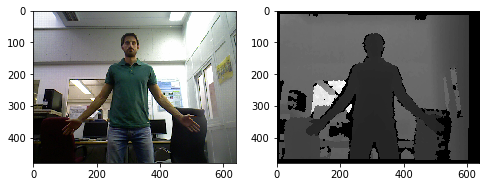

In [13]:
# ASSIGNMENT 3a --
image1 = cv2.imread(images_path + 'person_rgb.png', -1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

image2 = cv2.imread(images_path + 'person_depth.png', 0)

plt.subplot(121)
plt.imshow(image1)
plt.subplot(122)
plt.imshow(image2, cmap='gray')

As you can see, the depth image represents the depth with levels of grey color, the darker it is a pixel, the closer to the camera it is. So, for each pixel there is **a map intensity $\rightarrow$ depth**. Since we have the actual depth of the points, we just need to get the projection lines of the pixels in the image and then select the Z of the point according to the depth.

First, we need to transform the points in **image coordinates** to **sensor coordinates**. For this, we reverse the sensor to image method seen previously, either by using the pseudoinverse matrix or by **isolating the variables**.

We know that *(assuming that the axis scale is 1)*:

$$\bf{2D \rightarrow 2D} \qquad \underbrace{\begin{bmatrix} x' \\ y'\\ 1 \end{bmatrix}}_{\text{pixels}} = \begin{bmatrix} f &amp; 0 &amp; x_0  \\ 0 &amp; f &amp; y_0 \\ 0 &amp; 0 &amp; 1 \end{bmatrix} \underbrace{\begin{bmatrix} x \\ y\\ 1 \end{bmatrix}}_{\text{meters}}$$

If we isolate $x$ and $y$, we get the coordinates in the sensor:

$$\begin{eqnarray} x = \frac{x'-x_0}{f}, \; y = \frac{y'-y_0}{f} \end{eqnarray}$$

Finally, we add the depth component $Z$, which it's available in the depth image:

$$\bf{3D \rightarrow 2D} \; \ \text{for} \; \ f=1 \quad \begin{bmatrix} X \\ Y\\ Z \end{bmatrix} = Z \begin{bmatrix} x \\ y\\ 1 \end{bmatrix}$$

**<span style="color: red;">ASSIGNMENT 3b -- </span>**

Generate a $[3\times N]$ matrix with the 3D camera frame coordinates of all pixels in the image `person_rgb.png` using this intrinsic parameters:

$
f = 525, \
k_x = 1, \
k_y = 1, \
x_0 = 319.5, \
y_0 = 239.5 \
$

*Note that python indexing for a matrix starts in the top-left corner, you will have to adapt the transformation before applying the formula above.*

In [14]:
# ASSIGNMENT 3b --
f = 525
kx = 1
ky = 1
x0 = 319.5
y0 = 239.5

F = image1.shape[0]
C = image1.shape[1]

pos = np.zeros((3, F*C))
pos[2,:] = np.ones((1, F*C))
pos_depth = np.zeros(F*C)

for fil in range (F):
    for col in range(C):
        pos[0, fil*C + col] = col
        pos[1, fil*C + col] = fil-1
        pos_depth[fil*C + col] = image2[fil, col]

pos_metros = pos
pos_metros[0,:] = (pos[0,:]-x0)/f
pos_metros[1,:] = -(pos[1,:]-y0)/f

map_3d = pos_metros * pos_depth

print(map_3d[:,100060:100063])

[[-15.35142857 -15.19714286 -15.04285714]
 [ 13.03714286  13.03714286  13.03714286]
 [ 81.          81.          81.        ]]


You can **check if your results are correct** (Positions of the points nº 100060, 100061 and 100062 in the camera frame):

<font>**Expected output:**  </font>

    [[-15.35142857 -15.19714286 -15.04285714]
     [ 13.03714286  13.03714286  13.03714286]
     [ 81.          81.          81.        ]]



And here comes the fun (or funnier) part! We have developed (and we have provided to you) a 3D scatter plot for this exercise called `plot3DScene`, which shows a 3D colored pointcloud obtained from an RGB-D image as the one we have just obtained. 

Call the method `plot3DScene`, which takes as input the 3D coordinates of the points (a $[3\times N]$ matrix) and the original RGB image to get the color of each pixel.

In [ ]:
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

# Let's draw the pointcloud!
plot3DScene(map_3d,image1)

This is what you should get:

<img src="images/pointcloud.png" width="600">$\\[5pt]$

You can see how all the pixels in the image have been back-projected to 3D and we have a fancy pointcloud showing our scene in 3D. Now all those points are in the `WORLD` reference system and we can move our camera in order to get an image from a different perspective. Let's go for it.

So, in this last exercise we are going to move the camera position and project the pointcloud again to form a new 2D image of it. This implies:
- there is a rotation and translation between the `WORLD` and `CAMERA` reference systems, so we need to compute the point coordinates in the latter,
- then, we need to project those points to the sensor plane,
- then, we need to scale and translate such points in the sensor plane to an *computer image plane*,
- and finally, we need to adjust their coordinates to get the image plane with origin at the top-left.

Therefore, you should use the full projective transformation from the world reference frame to the image:

$$\lambda \begin{bmatrix} x' \\ y'\\ 1 \end{bmatrix} = \begin{bmatrix} f  &amp; 0 &amp; x'_0  \\ 0 &amp; f  &amp; y'_0 \\ 0 &amp; 0 &amp; 1 \end{bmatrix} \begin{bmatrix} \bf{R} &amp; \bf{t}\end{bmatrix} \begin{bmatrix} X_W \\ Y_W\\ Z_W \\ 1 \end{bmatrix} \qquad \bf{\lambda \tilde{m}' = K \left[ R\ t \right] \tilde{M}_W}$$

Note that, once we move the camera, there will be some 3D points that will be projected to the same pixel in the image (they will be in the same ray), so it is necessary to choose the points that are closer to the camera position, by using again the depth band.

**<span style="color: red;">ASSIGNMENT 3c -- </span>**

Define a rotation of 15º in the $Y$ axis and a translation of -0.5m in the $Z$ axis to move the camera. Then, apply the complete camera model to the previous computed 3D pointcloud in order to reproduce an image showing what the camera would see from that new position.


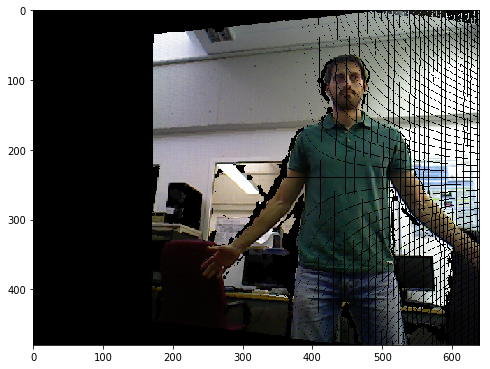

In [17]:
# ASSIGNMENT 3c --
theta = radians(15)
transformation = np.asarray([[cos(theta), 0, sin(theta), 0], [0, 1, 0, 0], [-sin(theta), 0, cos(theta), -0.5]])
met2pix = np.array([[f, 0, x0], [0, f, y0], [0, 0, 1]])
map_3d2 = np.vstack((map_3d, np.ones((1, image1.shape[0]*image1.shape[1]))))

px = met2pix@transformation@map_3d2 # Nueva posicion de los píxeles
px = px[:2,:] / px[2,:]
px = px.astype(int)

F = image1.shape[0]
C = image1.shape[1]

finalImage = np.zeros((image1.shape[0], image1.shape[1], 3)) # Nueva imagen donde se va a hacer la proyeccion (inicialmente negra)
finalImage_Z = np.zeros((image1.shape[0], image1.shape[1]))

for fil in range(finalImage.shape[0]):
    for col in range(finalImage.shape[1]):
        columna = px[0, fil*C + col] # Se obtiene la posición destino de cada pixel
        fila = px[1, fil*C + col]
        if columna < C and fila < F: # Si no se sale del rango
            if finalImage[fila,columna,0] == 0 and finalImage[fila,columna,1] == 0 and finalImage[fila,columna,2] == 0: # si no hay ningún otro pixel, se pone ese
                finalImage_Z[fila,columna] = image2[fil,col]
                finalImage[fila,columna,:] = image1[fil,col,:]
            elif finalImage[fila,columna,0] != 0 or finalImage[fila,columna,1] != 0 or finalImage[fila,columna,2] != 0: #si hay otro pixel, se comprueba la menor Z
                actualZ = image2[fil,col]
                if actualZ < finalImage_Z[fila, columna]:
                    finalImage_Z[fila,columna] = actualZ
                    finalImage[fila,columna,:] = image1[fil,col,:]

finalImage = finalImage.astype(np.uint8)
finalImage = np.flip(finalImage,0)

plt.imshow(finalImage)

This is the resulting image you should have obtained:

<img src="images/new_render.png" width="700">$\\[5pt]$

You can see how now we have a new perspective of the point cloud! Cool, right?

## Conclusion

Brilliant! Although this has been a dense chapter, it has been satisfying once you get it. In this notebook, you have learned:

- the principle of RGB-D images (widely used in computer vision and robotics fields nowadays),
- how the pinhole camera model works,
- how a more complete camera model works,
- how to project a 3D set of points to a 2D image,
- how to back-project an image with depth information to the 3D space to get a pointcloud